<a href="https://colab.research.google.com/github/sarmi2325/EconoCast/blob/main/Univariant_forecasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
#import library
import yfinance as yf
import pandas as pd
# univariant
df=yf.download('TSLA', start='2018-01-01', end='2024-12-31')
df=df[['Close']]
df.head()

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


Price,Close
Ticker,TSLA
Date,
2018-01-02,21.368668
2018-01-03,21.150000
2018-01-04,20.974667
2018-01-05,21.105333
2018-01-08,22.427334


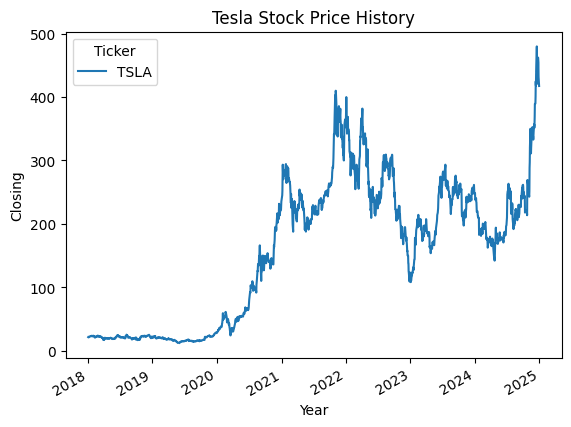

In [5]:
import matplotlib.pyplot as plt
df['Close'].plot(xlabel='Year',ylabel='Closing',title="Tesla Stock Price History")
plt.show()

In [6]:
#checking the datatype, and whether datetime is set to index
df.index

DatetimeIndex(['2018-01-02', '2018-01-03', '2018-01-04', '2018-01-05',
               '2018-01-08', '2018-01-09', '2018-01-10', '2018-01-11',
               '2018-01-12', '2018-01-16',
               ...
               '2024-12-16', '2024-12-17', '2024-12-18', '2024-12-19',
               '2024-12-20', '2024-12-23', '2024-12-24', '2024-12-26',
               '2024-12-27', '2024-12-30'],
              dtype='datetime64[ns]', name='Date', length=1760, freq=None)

In [23]:
df.resample('YE').mean()['Close'].idxmax()

,0
Ticker,
TSLA,2022-12-31


In [7]:
#lstm uses sigmoid and tanh, so normalizing the data
from sklearn.preprocessing import MinMaxScaler
close_prices = df['Close'].values.reshape(-1,1)

scaler = MinMaxScaler()
scaled_close_prices = scaler.fit_transform(close_prices)


In [8]:
#passing the data to get sequence of 60
import numpy as np
def sequence(data,window_size):
  X=[]
  y=[]
  for i in range(len(data)-window_size):
    X.append(data[i:i+window_size])
    y.append(data[i+window_size])
  return np.array(X),np.array(y)
WINDOW = 60

X,y = sequence(scaled_close_prices,WINDOW)
print(f"X shape: {X.shape}, y shape: {y.shape}")

X shape: (1700, 60, 1), y shape: (1700, 1)


In [9]:
from sklearn.model_selection import train_test_split

# Split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, shuffle=False
)

# Reshape input for LSTM (already in shape: samples, time_steps, features)
print(f"Train shape: {X_train.shape}, Test shape: {X_test.shape}")


Train shape: (1360, 60, 1), Test shape: (340, 60, 1)


In [10]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

model = Sequential([
    LSTM(units=50, return_sequences=False, input_shape=(X_train.shape[1], 1)),
    Dropout(0.2),
    Dense(1)  # Output layer: 1 value (next day's price)
])

model.compile(optimizer='adam', loss='mean_squared_error')
model.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 50)             │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,451 (40.82 KB)

 Trainable params: 10,451 (40.82 KB)

 Non-trainable params: 0 (0.00 B)

In [11]:
#fit the model
history = model.fit(
    X_train, y_train,
    epochs=10,
    batch_size=32,
    validation_data=(X_test, y_test),
    verbose=1 #used to set the logging level during the model training and validation process
)


Epoch 1/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 4s 39ms/step - loss: 0.0980 - val_loss: 0.0062
Epoch 2/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0050 - val_loss: 0.0019
Epoch 3/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - loss: 0.0026 - val_loss: 0.0018
Epoch 4/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0023 - val_loss: 0.0017
Epoch 5/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0019 - val_loss: 0.0016
Epoch 6/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 3s 41ms/step - loss: 0.0017 - val_loss: 0.0019
Epoch 7/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - loss: 0.0017 - val_loss: 0.0019
Epoch 8/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0019 - val_loss: 0.0015
Epoch 9/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - loss: 0.0018 - val_loss: 0.0019
Epoch 10/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - loss: 0.0018 - val_loss: 0.0015


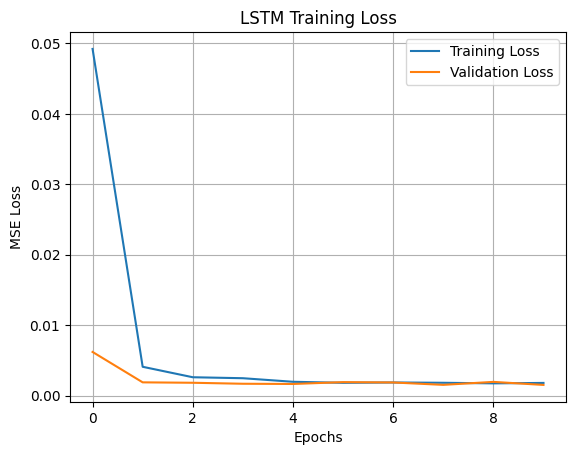

In [13]:
#plotting the training loss vs the validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title("LSTM Training Loss")
plt.xlabel("Epochs")
plt.ylabel("MSE Loss")
plt.legend()
plt.grid(True)
plt.show()


In [14]:
# Predict
predictions = model.predict(X_test)

# Inverse transform to get actual price values
predicted_prices = scaler.inverse_transform(predictions)
real_prices = scaler.inverse_transform(y_test)

print("Predicted shape:", predicted_prices.shape)


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step
Predicted shape: (340, 1)


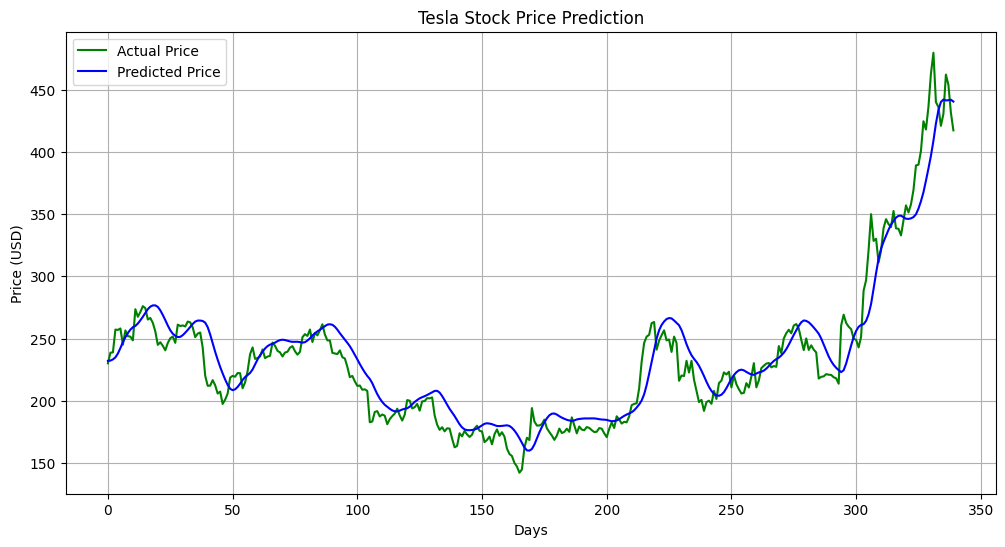

In [15]:
plt.figure(figsize=(12,6))
plt.plot(real_prices, label="Actual Price", color='green')
plt.plot(predicted_prices, label="Predicted Price", color='blue')
plt.title("Tesla Stock Price Prediction")
plt.xlabel("Days")
plt.ylabel("Price (USD)")
plt.legend()
plt.grid(True)
plt.show()


In [16]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

mse = mean_squared_error(real_prices, predicted_prices)
mae = mean_absolute_error(real_prices, predicted_prices)
rmse = np.sqrt(mse)

print(f"MAE: {mae:.2f}, RMSE: {rmse:.2f}")


MAE: 13.82, RMSE: 18.17
